In [1]:
import os
# set up the folders
PROJECT_DIR = "/Users/abraham/Documents/Work/Self/2024/resumeClassification"
datasets_dir = os.path.join(PROJECT_DIR, "datasets")
os.makedirs(datasets_dir, exist_ok=True)

In [2]:
image_dir = os.path.join(datasets_dir, 'images')

In [3]:
label_files = {
    'train' : os.path.join(datasets_dir, 'labels', 'train.txt'),
    'test' : os.path.join(datasets_dir, 'labels', 'test.txt'),
    'val' : os.path.join(datasets_dir, 'labels', 'val.txt')
}

In [4]:
# label all images in the dataset
labeled_images = {}
for _, filepath in label_files.items():
    with open(filepath, 'r') as f:
        for line in f:
            relative_path, label = line.strip().split(' ')
            full_path = os.path.join(image_dir, relative_path)
            # let resume be labeled 1 and others 0
            # in the dataset, a label of 14 is indicative of resume
            labeled_images[full_path] = 1 if label == '14' else 0

In [5]:
len(labeled_images)

400000

In [6]:
sum(label == 1 for label in labeled_images.values())

25000

In [7]:
import random

resumes = [path for path, label in labeled_images.items() if label == 1]
non_resumes = [path for path, label in labeled_images.items() if label == 0]

balanced_non_resumes = random.sample(non_resumes, len(resumes))
# Creating a new dictionary to be used as input into the CNN

In [8]:
bal_labeled_images = {path: 1 for path in resumes}
bal_labeled_images.update({path: 0 for path in balanced_non_resumes})

In [9]:
len(bal_labeled_images)

50000

In [10]:
import numpy as np
from typing import List, Tuple
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize

class ImageVectorizer:
    def __init__(self, dims: Tuple[int, int]) -> None:
        self.dims = dims
    
    def convert_image_to_array(
        self, image_path: str
    ) -> np.ndarray:
        image_array = imread(image_path)
        if len(image_array.shape) == 3: #rgb image
            image_array = rgb2gray(image_array)
        image_array = resize(
            image_array, (self.dims[0], self.dims[1]),
            anti_aliasing=True    
        )
        if image_array.ndim == 2:
            image_array = np.expand_dims(image_array, axis=-1)
        return image_array.astype(np.float32)

    def extract_features_from_images(
    
        self, image_paths: List[str]
    ) -> np.ndarray:
        """Extracts features from a list of images.

        Args:
            image_paths (List[str]): A list of images 

        Returns:
            np.ndarray: Features of the images
        """
        num_images = len(image_paths)
        # initialize with zeros
        image_features = np.zeros(
            (num_images, self.dims[0], self.dims[1], 1),
            dtype=np.float32
        )
        for idx, img_path in enumerate(image_paths):
            image_features[idx] = self.convert_image_to_array(img_path)
        return image_features

In [11]:
from typing import Dict
def extract_features_and_labels(
    labeled_images: Dict[str, int], vectorizer: ImageVectorizer
)-> Tuple[np.ndarray, np.ndarray]:
    image_paths = list(labeled_images.keys())
    labels = list(labeled_images.values())
    # Extract features
    image_features = vectorizer.extract_features_from_images(image_paths)
    #split the data into test and training datasets
    X_train, X_test, y_train, y_test = train_test_split(
        image_features, labels, test_size=0.2, random_state=42
    )
    y_train = np.array(y_train, dtype=np.int32)
    y_test = np.array(y_test, dtype=np.int32)
    return X_train, X_test, y_train, y_test  

In [12]:
dims = (256, 256)
img_vectorizer = ImageVectorizer(dims=dims)

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = extract_features_and_labels(
    bal_labeled_images, img_vectorizer
)

In [14]:
from tensorflow.keras import models, layers, optimizers, callbacks


class ResumeClassifierCNNModel:
    def __init__(self, image_shape, checkpoint_dir):
        self.image_shape = image_shape
        self.checkpoint_dir = checkpoint_dir
        self.model = self._build_model()
        self._compile_model()
        
    def _build_model(self):
        model = models.Sequential([
            layers.Input(shape=self.image_shape),
            
            layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
            layers.MaxPooling2D((2, 2), padding='same'),
            layers.Dropout(0.2),
            
            layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
            layers.MaxPooling2D((2, 2), padding='same'),
            layers.Dropout(0.3),
            
            layers.GlobalAveragePooling2D(),
            
            layers.Dense(1, activation='sigmoid')
        ])
        return model


    def _compile_model(self):
        optimizer = optimizers.Adam(learning_rate=0.00005)
        self.model.compile(
            optimizer=optimizer, loss='binary_crossentropy', 
            metrics=['accuracy']
            )
        os.makedirs(self.checkpoint_dir, exist_ok=True)
        checkpoint_filepath = os.path.join(self.checkpoint_dir, 'resumeModel_best.keras')

        self.callbacks = [
            callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1),
            callbacks.ModelCheckpoint(
                filepath=checkpoint_filepath,
                monitor='val_loss',
                save_best_only=True,
                verbose=1
            )
        ]
    
    def get_model(self):
        return self.model

In [15]:
batch_size = 32
epochs = 20
image_shape = (dims[0], dims[1], 1)
checkpoint_dir = os.path.join(PROJECT_DIR, 'models')
resume_model = ResumeClassifierCNNModel(image_shape, checkpoint_dir)
model = resume_model.get_model()
model.fit(
    X_train, y_train, batch_size=batch_size, epochs=epochs, 
    validation_data=(X_test, y_test), shuffle=True, callbacks=resume_model.callbacks
)

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.5546 - loss: 0.6898
Epoch 1: val_loss improved from inf to 0.67069, saving model to /Users/abraham/Documents/Work/Self/2024/resumeClassification/models/resumeModel_best.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 296s 236ms/step - accuracy: 0.5547 - loss: 0.6898 - val_accuracy: 0.7226 - val_loss: 0.6707
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.6719 - loss: 0.6645
Epoch 2: val_loss improved from 0.67069 to 0.64243, saving model to /Users/abraham/Documents/Work/Self/2024/resumeClassification/models/resumeModel_best.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 288s 230ms/step - accuracy: 0.6719 - loss: 0.6645 - val_accuracy: 0.7364 - val_loss: 0.6424
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.7206 - loss: 0.6379
Epoch 3: val_loss improved from 0.64243 to 0.61497, saving model to /Users/abraham/Documents/Work/Self/2024/resumeClassification/models/resumeModel_best.keras
1250/1250 ━

In [16]:
from tensorflow.keras.models import load_model
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

loaded_model = load_model(os.path.join(checkpoint_dir, 'resumeModel_best.keras'))
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype('int32')
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step
Accuracy: 0.8059
Precision: 0.7965351299326275
Recall: 0.8239745121465551
F1 Score: 0.8100225115004405


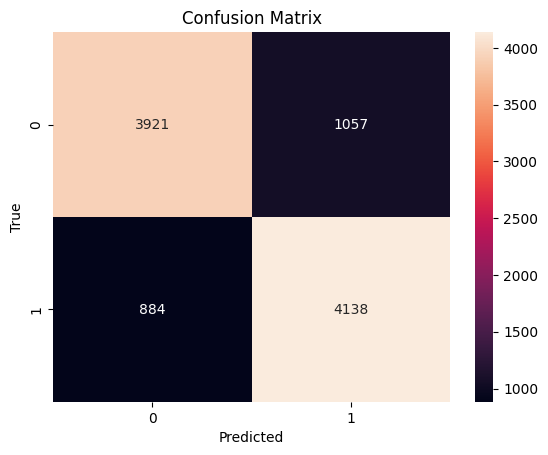

In [17]:
# Generating and visualizing the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()